In [1]:
import os
import copy
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import f1_score, classification_report

import lightning as L
from lightning import Fabric
from src.resnet_modifications import resnet18
from typing import List, Tuple
from src.gen_alg import GeneticAlgorithm
from IPython.display import clear_output
from src.models import AlexNetInception1x1, AlexNetSeparable11, AlexNetSkipConnection, AlexNetWithBatchNorm, AlexNetWithSilu

In [2]:
DATA_DIR = 'data/img_align_celeba/img_align_celeba/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ys = pd.read_csv('data/list_attr_celeba.csv')

In [3]:
import pickle
with open('results/true_images.pickle', 'rb') as f:
    true_images_x, true_images_y = pickle.load(f)

In [4]:
true_images_x = true_images_x[:30]
true_images_y = true_images_y[:30]
true_images_x.shape, true_images_y.shape 

((30,), (30,))

In [5]:
val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [6]:
# Генераторы значений для генов
def make_gene_ranges(image_shape: Tuple[int, int], diameter: int) -> List[List[int]]:
    H, W = image_shape
    # x, y и три цветовых канала (0–254)
    return [
        list(range(0, H - diameter + 1)),  # x
        list(range(0, W - diameter + 1)),  # y
        list(range(255)),                  # R
        list(range(255)),                  # G
        list(range(255)),                  # B
    ]

# Представление «атаки» как тройки (x, y, [r, g, b])
Perturbation = Tuple[int, int, List[int]]

def apply_perturbation(image: np.ndarray, p: Perturbation, diameter: int) -> None:
    x, y, (r, g, b) = p
    for dx in range(diameter):
        for dy in range(diameter):
            image[x + dx, y + dy] = [r, g, b]

def individual_to_perturbations(ind: List[int], pixels_count: int) -> List[Perturbation]:
    """Разбивает список из генов на несколько Perturbation в зависимости от количества пикселей"""
    parts = []
    for i in range(pixels_count):
        start_idx = i * 5
        x, y, r, g, b = ind[start_idx:start_idx + 5]
        parts.append((x, y, [r, g, b]))
    return parts

def fit(individuals: List[List[int]], args: dict) -> List[float]:
    base_img = args['img']
    model = args['model']
    true_id = args['true_id']
    diameter = args['diameter']
    pixels_count = args['pixels_count']
    trasform = args['transform']
    transformed = []

    # Для каждого решения собираем батч из преобразованных изображений
    for ind in individuals:
        img_copy = base_img.copy()
        for p in individual_to_perturbations(ind, pixels_count):
            apply_perturbation(img_copy, p, diameter)
        pil_img = Image.fromarray(img_copy)
        transformed.append(trasform(pil_img).unsqueeze(0))

    batch = torch.cat(transformed, dim=0).to(DEVICE)
    with torch.no_grad():
        logits = model(batch).squeeze(1).cpu()
        scores = torch.sigmoid(logits).numpy()

    # Приводим к метрике «чем меньше — тем лучше» (для true_id=1)
    return [1 - s if true_id == 1 else float(s) for s in scores]

def get_individual(gens: List[List[int]], pixels_count: int) -> List[int]:
    """Создаёт случайного индивида из нескольких Perturbation подряд"""
    ind = []
    for _ in range(pixels_count):
        # выбираем x, y и три канала
        for gene_idx in range(5):
            gene_pool = gens[gene_idx]
            ind.append(int(np.random.choice(gene_pool)))
    return ind

def mutate(ind: List[int], gens: List[List[int]], eps: float, pixels_count: int) -> List[int]:
    """С вероятностью eps мутирует каждый ген"""
    out = []
    for idx, val in enumerate(ind):
        if np.random.rand() < eps:
            pool = gens[idx % 5]
            out.append(int(np.random.choice(pool)))
        else:
            out.append(val)
    return out

def ga_one_pixel_attack(
    img: Image.Image, 
    true_label: int,
    model: torch.nn.Module, 
    pixels_count: int = 3,
    diameter: int = 1, 
    population_size: int = 1000, 
    batch_size: int = 1000,
    epochs: int = 1000,
    transform=val_tfms,
    epsilon_start: float = 0.3, 
    epsilon_end: float = 0.01, 
    alpha: float = 0.01, 
    timeout: float = float('inf'),
    leaders_ratio: float = 0.1, 
    survivors_ratio: float = 0.2, 
    new_ratio: float = 0.4) -> None:
    """Функция для запуска генетического алгоритма на атаке пикселей изображения"""

    # Загрузка изображения
    img_np = np.array(img)

    gen_len = 5 * pixels_count

    gens = make_gene_ranges(img_np.shape[:2], diameter)
    args = {
        'img': img_np,
        'true_id': true_label,
        'model': model,
        'diameter': diameter,
        'pixels_count': pixels_count,
        'timeout': timeout,
        'transform': transform
    }

    ga = GeneticAlgorithm(
        gen_len=gen_len,
        population_size=population_size,
        fit_fun=fit,
        individual_create_fun=lambda: get_individual(gens, pixels_count),
        individual_mutation_fun=lambda ind, epsilon: mutate(ind, gens, epsilon, pixels_count),
        args=args,
        epoch_count=epochs,
        epsilon=epsilon_start,
        min_epsilon=epsilon_end,
        alpha=alpha,
        leaders_ration=leaders_ratio,
        survivors_ratio=survivors_ratio,
        new_individual_ratio=new_ratio,
        n_jobs=0,
        crossing_operator='uniform',
        batch_size=batch_size
    )
    ga.start()

    return ga.generation[0]

# AlexNet

## AlexNet vanilla

In [7]:
alexnet_model = models.alexnet()
alexnet_model.classifier[6] = nn.Linear(4096, 1) 
alexnet_model.load_state_dict(torch.load('models/best_alexnet.pth'))
alexnet_model.eval()
alexnet_model.to(DEVICE)
pass

In [8]:
%%time
alexnet_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_results.append(attack)
    clear_output()

CPU times: user 7h 50min 15s, sys: 22min 34s, total: 8h 12min 50s
Wall time: 2h 37min 15s


In [9]:
import pickle
with open('results/_result_alexnet.pickle', 'wb') as f:
    pickle.dump(alexnet_results, f)

In [10]:
alexnet_results

[[26,
  16,
  111,
  71,
  8,
  161,
  88,
  241,
  3,
  68,
  108,
  76,
  73,
  85,
  178,
  0.5434430837631226],
 [123,
  156,
  77,
  85,
  112,
  107,
  62,
  200,
  245,
  229,
  139,
  88,
  83,
  232,
  211,
  0.5197458863258362],
 [130,
  61,
  2,
  12,
  1,
  127,
  107,
  7,
  1,
  0,
  123,
  94,
  11,
  1,
  248,
  np.float32(0.05776465)],
 [111,
  113,
  243,
  223,
  180,
  110,
  62,
  17,
  171,
  185,
  110,
  74,
  217,
  11,
  151,
  0.5036863684654236],
 [91,
  75,
  14,
  14,
  37,
  161,
  88,
  236,
  1,
  0,
  157,
  83,
  246,
  38,
  0,
  0.0026982924900949],
 [108,
  113,
  90,
  184,
  6,
  107,
  81,
  11,
  236,
  194,
  115,
  76,
  0,
  251,
  149,
  0.0002748105034697801],
 [130,
  106,
  79,
  127,
  239,
  189,
  117,
  83,
  167,
  161,
  129,
  70,
  7,
  109,
  111,
  np.float32(0.5587188)],
 [165,
  87,
  187,
  211,
  241,
  162,
  87,
  253,
  3,
  184,
  122,
  100,
  93,
  175,
  245,
  0.002541575115174055],
 [159,
  84,
  2,
  0,
  228,
  1

In [13]:
len([e[15] for e in alexnet_results if e[15] > 0.5])

9

In [16]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_results])

np.float64(0.20131976059055887)

## AlexNet Dropout

In [17]:
alexnet_model_do = models.alexnet(dropout=0.8)
alexnet_model_do.classifier[6] = nn.Linear(4096, 1) 
alexnet_model_do.load_state_dict(torch.load('models/best_alexnet_do.pth'))
alexnet_model_do.eval()
alexnet_model_do.to(DEVICE)
pass

In [18]:
%%time
alexnet_results_do = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model_do,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_results_do.append(attack)
    with open('results/_result_alexnet_do.pickle', 'wb') as f:
        pickle.dump(alexnet_results_do, f)
    clear_output()

CPU times: user 8h 39min 34s, sys: 24min 16s, total: 9h 3min 51s
Wall time: 2h 54min 31s


In [19]:

with open('results/_result_alexnet_do.pickle', 'wb') as f:
    pickle.dump(alexnet_results_do, f)

In [20]:
alexnet_results_do

[[112,
  113,
  10,
  251,
  254,
  107,
  68,
  245,
  206,
  235,
  108,
  99,
  12,
  245,
  251,
  0.5001605153083801],
 [115,
  62,
  8,
  253,
  203,
  108,
  62,
  1,
  254,
  254,
  111,
  68,
  0,
  253,
  250,
  0.33283883333206177],
 [130,
  107,
  4,
  9,
  3,
  136,
  101,
  38,
  14,
  0,
  128,
  68,
  8,
  5,
  29,
  np.float32(0.06240648)],
 [112,
  62,
  18,
  250,
  236,
  111,
  100,
  4,
  252,
  229,
  141,
  6,
  87,
  198,
  93,
  0.5191090703010559],
 [98,
  79,
  10,
  17,
  31,
  99,
  94,
  8,
  12,
  46,
  95,
  75,
  80,
  7,
  3,
  0.0031600433867424726],
 [98,
  75,
  7,
  222,
  1,
  111,
  113,
  1,
  248,
  202,
  13,
  27,
  171,
  245,
  97,
  0.0021042288281023502],
 [171,
  85,
  210,
  119,
  188,
  130,
  101,
  118,
  5,
  81,
  129,
  63,
  11,
  9,
  234,
  np.float32(0.5036266)],
 [169,
  81,
  3,
  186,
  170,
  108,
  84,
  220,
  223,
  244,
  115,
  72,
  50,
  245,
  249,
  0.0007867691456340253],
 [143,
  58,
  53,
  225,
  178,
  106,

In [21]:
len([e[15] for e in alexnet_results_do if e[15] > 0.5])

8

In [22]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_results_do])

np.float64(0.19955977393741098)

In [23]:
alexnet_results_do

[[112,
  113,
  10,
  251,
  254,
  107,
  68,
  245,
  206,
  235,
  108,
  99,
  12,
  245,
  251,
  0.5001605153083801],
 [115,
  62,
  8,
  253,
  203,
  108,
  62,
  1,
  254,
  254,
  111,
  68,
  0,
  253,
  250,
  0.33283883333206177],
 [130,
  107,
  4,
  9,
  3,
  136,
  101,
  38,
  14,
  0,
  128,
  68,
  8,
  5,
  29,
  np.float32(0.06240648)],
 [112,
  62,
  18,
  250,
  236,
  111,
  100,
  4,
  252,
  229,
  141,
  6,
  87,
  198,
  93,
  0.5191090703010559],
 [98,
  79,
  10,
  17,
  31,
  99,
  94,
  8,
  12,
  46,
  95,
  75,
  80,
  7,
  3,
  0.0031600433867424726],
 [98,
  75,
  7,
  222,
  1,
  111,
  113,
  1,
  248,
  202,
  13,
  27,
  171,
  245,
  97,
  0.0021042288281023502],
 [171,
  85,
  210,
  119,
  188,
  130,
  101,
  118,
  5,
  81,
  129,
  63,
  11,
  9,
  234,
  np.float32(0.5036266)],
 [169,
  81,
  3,
  186,
  170,
  108,
  84,
  220,
  223,
  244,
  115,
  72,
  50,
  245,
  249,
  0.0007867691456340253],
 [143,
  58,
  53,
  225,
  178,
  106,

## with SiLU

In [7]:
alexnet_model_silu = AlexNetWithSilu()
alexnet_model_silu.load_state_dict(torch.load('models/best_alexnet_silu.pth'))
alexnet_model_silu.eval()
alexnet_model_silu.to(DEVICE)
pass

In [8]:
%%time
alexnet_results_silu = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model_silu,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_results_silu.append(attack)
    with open('results/_result_alexnet_silu.pickle', 'wb') as f:
        pickle.dump(alexnet_results_silu, f)
    clear_output()

0/30, 182638.jpg
epoch 0	 mean: 0.17	 max: 0.31	 time: 1.07


KeyboardInterrupt: 

In [ ]:

with open('results/_result_alexnet_silu.pickle', 'wb') as f:
    pickle.dump(alexnet_results_silu, f)

In [12]:
alexnet_results_silu

[[107,
  69,
  229,
  235,
  234,
  101,
  108,
  164,
  1,
  203,
  198,
  81,
  155,
  18,
  46,
  0.5199899673461914],
 [110,
  64,
  0,
  254,
  241,
  112,
  63,
  7,
  253,
  253,
  112,
  101,
  65,
  127,
  8,
  0.5127051472663879],
 [128,
  106,
  4,
  30,
  2,
  130,
  112,
  1,
  18,
  0,
  123,
  69,
  4,
  9,
  8,
  np.float32(0.039242208)],
 [101,
  100,
  223,
  82,
  253,
  162,
  80,
  217,
  50,
  242,
  110,
  101,
  111,
  234,
  249,
  0.5252360701560974],
 [112,
  107,
  29,
  252,
  231,
  99,
  100,
  197,
  4,
  7,
  110,
  56,
  8,
  7,
  248,
  0.00369615969248116],
 [159,
  87,
  188,
  16,
  171,
  110,
  100,
  1,
  26,
  252,
  114,
  117,
  2,
  19,
  253,
  0.001123082940466702],
 [116,
  82,
  192,
  7,
  7,
  129,
  100,
  28,
  46,
  78,
  123,
  69,
  6,
  4,
  4,
  np.float32(0.51181716)],
 [107,
  67,
  252,
  254,
  226,
  181,
  40,
  254,
  22,
  226,
  108,
  92,
  229,
  254,
  211,
  0.0009524253546260297],
 [201,
  38,
  66,
  153,
  34,
  

In [13]:
len([e[15] for e in alexnet_results_silu if e[15] > 0.5])

7

In [14]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_results_silu])

np.float64(0.18194562539865727)

## AlexNet pretrain

In [7]:
alexnet_model_pretrain = models.alexnet()
alexnet_model_pretrain.classifier[6] = nn.Linear(4096, 1) 
alexnet_model_pretrain.load_state_dict(torch.load('models/best_alexnet_pretrain.pth'))
alexnet_model_pretrain.eval()
alexnet_model_pretrain.to(DEVICE)
pass

In [8]:
%%time
alexnet_pretrain_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model_pretrain,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_pretrain_results.append(attack)
    clear_output()

CPU times: user 7h 31min 37s, sys: 22min 4s, total: 7h 53min 42s
Wall time: 2h 31min 52s


In [9]:
import pickle
with open('results/_result_alexnet_pretrain.pickle', 'wb') as f:
    pickle.dump(alexnet_pretrain_results, f)

In [10]:
alexnet_pretrain_results

[[149,
  89,
  231,
  18,
  177,
  161,
  31,
  167,
  9,
  203,
  151,
  89,
  245,
  41,
  160,
  0.6184799671173096],
 [102,
  62,
  5,
  161,
  135,
  16,
  141,
  6,
  249,
  205,
  129,
  89,
  109,
  214,
  236,
  0.6419793367385864],
 [129,
  107,
  0,
  0,
  254,
  130,
  59,
  0,
  0,
  40,
  114,
  84,
  0,
  0,
  254,
  np.float32(0.32536185)],
 [153,
  45,
  219,
  138,
  182,
  149,
  86,
  249,
  218,
  182,
  150,
  33,
  234,
  172,
  35,
  0.5166187882423401],
 [97,
  103,
  0,
  0,
  101,
  150,
  71,
  254,
  0,
  4,
  96,
  78,
  247,
  7,
  219,
  0.04778747633099556],
 [149,
  51,
  246,
  251,
  245,
  144,
  128,
  254,
  235,
  243,
  111,
  77,
  249,
  1,
  213,
  0.03975354880094528],
 [84,
  92,
  57,
  7,
  193,
  126,
  66,
  11,
  6,
  47,
  100,
  84,
  12,
  23,
  19,
  np.float32(0.57522607)],
 [144,
  84,
  2,
  254,
  254,
  182,
  66,
  252,
  254,
  250,
  142,
  90,
  254,
  0,
  252,
  0.17432090640068054],
 [64,
  137,
  191,
  43,
  91,
  85,

In [11]:
len([e[15] for e in alexnet_pretrain_results if e[15] > 0.5])

13

In [12]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_pretrain_results])

np.float64(0.31002729351942737)

## with 1x1 kernels

In [15]:
alexnet_model_1x1 = AlexNetInception1x1()
alexnet_model_1x1.load_state_dict(torch.load('models/best_alexnet_1x1.pth'))
alexnet_model_1x1.eval()
alexnet_model_1x1.to(DEVICE)
pass

In [16]:
%%time
alexnet_1x1_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model_1x1,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_1x1_results.append(attack)
    clear_output()

CPU times: user 8h 39min 24s, sys: 25min 25s, total: 9h 4min 49s
Wall time: 2h 58min 13s


In [17]:
import pickle
with open('results/_result_alexnet_1x1.pickle', 'wb') as f:
    pickle.dump(alexnet_1x1_results, f)

In [21]:
alexnet_1x1_results

[[108,
  72,
  137,
  3,
  249,
  97,
  69,
  43,
  3,
  55,
  192,
  70,
  210,
  9,
  181,
  0.5082158446311951],
 [12,
  172,
  204,
  114,
  65,
  103,
  60,
  179,
  196,
  166,
  113,
  65,
  162,
  211,
  243,
  0.5114189386367798],
 [136,
  101,
  2,
  0,
  245,
  131,
  63,
  5,
  9,
  7,
  128,
  114,
  13,
  8,
  18,
  np.float32(0.014099538)],
 [110,
  116,
  29,
  254,
  247,
  152,
  104,
  24,
  155,
  237,
  110,
  104,
  0,
  186,
  209,
  0.5247921943664551],
 [100,
  87,
  14,
  7,
  11,
  98,
  82,
  9,
  2,
  2,
  157,
  82,
  3,
  0,
  246,
  0.023987101390957832],
 [161,
  81,
  0,
  3,
  254,
  98,
  75,
  45,
  34,
  6,
  146,
  90,
  15,
  253,
  178,
  0.0009170561097562313],
 [128,
  82,
  102,
  2,
  141,
  130,
  97,
  107,
  80,
  225,
  136,
  104,
  186,
  0,
  27,
  np.float32(0.53425)],
 [121,
  72,
  50,
  250,
  231,
  165,
  84,
  171,
  212,
  235,
  96,
  100,
  5,
  6,
  80,
  0.001040165894664824],
 [99,
  75,
  92,
  51,
  50,
  116,
  72,
  7

In [22]:
len([e[15] for e in alexnet_1x1_results if e[15] > 0.5])

9

In [23]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_1x1_results])

np.float64(0.226492360146464)

## with 11x1 and 1x11

In [24]:
alexnet_model_1x11 = AlexNetSeparable11()
alexnet_model_1x11.load_state_dict(torch.load('models/best_alexnet_11.pth'))
alexnet_model_1x11.eval()
alexnet_model_1x11.to(DEVICE)
pass

In [25]:
%%time
alexnet_1x11_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model_1x11,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_1x11_results.append(attack)
    clear_output()

CPU times: user 8h 59min 38s, sys: 25min 48s, total: 9h 25min 27s
Wall time: 3h 7min 57s


In [26]:
import pickle
with open('results/_result_alexnet_1x11.pickle', 'wb') as f:
    pickle.dump(alexnet_1x11_results, f)

In [27]:
alexnet_1x11_results

[[108,
  69,
  93,
  250,
  209,
  111,
  115,
  17,
  165,
  71,
  109,
  105,
  241,
  249,
  243,
  0.5086953043937683],
 [111,
  69,
  4,
  253,
  53,
  114,
  69,
  4,
  252,
  253,
  154,
  87,
  160,
  234,
  248,
  0.5178287029266357],
 [122,
  108,
  2,
  4,
  253,
  122,
  62,
  30,
  100,
  252,
  123,
  110,
  20,
  14,
  41,
  np.float32(0.023952842)],
 [111,
  67,
  14,
  197,
  253,
  111,
  113,
  32,
  248,
  113,
  146,
  87,
  46,
  216,
  254,
  0.533524215221405],
 [207,
  7,
  101,
  140,
  133,
  154,
  88,
  21,
  237,
  176,
  146,
  87,
  8,
  247,
  223,
  0.00025512411957606673],
 [146,
  100,
  31,
  236,
  200,
  98,
  145,
  55,
  127,
  19,
  115,
  62,
  2,
  7,
  55,
  0.00016936988686211407],
 [131,
  107,
  2,
  0,
  0,
  130,
  69,
  1,
  7,
  2,
  123,
  68,
  1,
  2,
  4,
  np.float32(0.49929708)],
 [140,
  65,
  19,
  138,
  4,
  124,
  105,
  52,
  245,
  229,
  170,
  87,
  2,
  223,
  254,
  0.006700456608086824],
 [162,
  70,
  175,
  222,
  

In [28]:
len([e[15] for e in alexnet_1x11_results if e[15] > 0.5])

8

In [29]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_1x11_results])

np.float64(0.20389431934357466)

## with scip-connection

In [31]:
alexnet_model_sc = AlexNetSkipConnection()
alexnet_model_sc.load_state_dict(torch.load('models/best_alexnet_skip_connection.pth'))
alexnet_model_sc.eval()
alexnet_model_sc.to(DEVICE)
pass

In [32]:
%%time
alexnet_sc_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model_sc,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_sc_results.append(attack)
    clear_output()

CPU times: user 9h 10min 4s, sys: 27min 24s, total: 9h 37min 29s
Wall time: 2h 58min 15s


In [33]:
import pickle
with open('results/_result_alexnet_sc.pickle', 'wb') as f:
    pickle.dump(alexnet_sc_results, f)

In [34]:
alexnet_sc_results

[[15,
  72,
  148,
  210,
  59,
  110,
  64,
  77,
  195,
  247,
  112,
  104,
  73,
  224,
  28,
  0.5062957406044006],
 [129,
  163,
  222,
  60,
  136,
  207,
  3,
  232,
  215,
  166,
  113,
  64,
  11,
  228,
  212,
  0.528236985206604],
 [130,
  66,
  26,
  1,
  0,
  130,
  108,
  6,
  2,
  7,
  52,
  72,
  235,
  238,
  249,
  np.float32(0.040685356)],
 [32,
  167,
  184,
  31,
  146,
  123,
  175,
  89,
  228,
  141,
  111,
  72,
  25,
  217,
  245,
  0.6034806966781616],
 [114,
  75,
  116,
  1,
  0,
  111,
  75,
  2,
  253,
  254,
  110,
  69,
  0,
  254,
  2,
  0.3332339823246002],
 [111,
  113,
  1,
  253,
  251,
  107,
  75,
  4,
  254,
  251,
  111,
  106,
  6,
  250,
  247,
  0.08346075564622879],
 [130,
  70,
  13,
  21,
  49,
  41,
  104,
  79,
  164,
  236,
  140,
  93,
  10,
  51,
  242,
  np.float32(0.5002925)],
 [114,
  72,
  221,
  230,
  253,
  114,
  104,
  235,
  240,
  252,
  110,
  105,
  34,
  244,
  254,
  0.013424888253211975],
 [111,
  110,
  253,
  1,
  

In [35]:
len([e[15] for e in alexnet_sc_results if e[15] > 0.5])

10

In [36]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_sc_results])

np.float64(0.30097518891173725)

## with BatchNorm

In [37]:
alexnet_model_bn = AlexNetWithBatchNorm()
alexnet_model_bn.load_state_dict(torch.load('models/best_alexnet_bn.pth'))
alexnet_model_bn.eval()
alexnet_model_bn.to(DEVICE)
pass

In [38]:
%%time
alexnet_bn_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model_bn,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_bn_results.append(attack)
    clear_output()

CPU times: user 8h 5min 13s, sys: 25min 31s, total: 8h 30min 45s
Wall time: 2h 44min 32s


In [39]:
import pickle
with open('results/_result_alexnet_bn.pickle', 'wb') as f:
    pickle.dump(alexnet_bn_results, f)

In [40]:
alexnet_bn_results

[[160,
  88,
  119,
  43,
  18,
  147,
  99,
  242,
  18,
  208,
  157,
  84,
  22,
  0,
  246,
  0.5134586095809937],
 [131,
  143,
  189,
  181,
  5,
  112,
  69,
  2,
  220,
  175,
  142,
  48,
  192,
  222,
  217,
  0.5215877890586853],
 [124,
  107,
  0,
  3,
  254,
  109,
  87,
  0,
  0,
  0,
  124,
  62,
  0,
  1,
  2,
  np.float32(0.38347965)],
 [111,
  114,
  12,
  130,
  244,
  146,
  69,
  3,
  145,
  254,
  112,
  100,
  5,
  250,
  249,
  0.5259304642677307],
 [95, 75, 3, 4, 2, 99, 78, 1, 5, 3, 129, 88, 4, 177, 6, 0.005866814870387316],
 [108,
  62,
  6,
  252,
  48,
  99,
  72,
  1,
  2,
  244,
  99,
  78,
  2,
  5,
  8,
  0.0027285965625196695],
 [122,
  106,
  33,
  4,
  250,
  132,
  69,
  12,
  27,
  118,
  165,
  94,
  101,
  17,
  70,
  np.float32(0.5263143)],
 [107,
  91,
  169,
  174,
  253,
  91,
  78,
  74,
  68,
  85,
  95,
  85,
  0,
  7,
  13,
  0.00027277180925011635],
 [69,
  94,
  57,
  199,
  246,
  152,
  49,
  90,
  226,
  253,
  145,
  93,
  136,
  235

In [41]:
len([e[15] for e in alexnet_bn_results if e[15] > 0.5])

9

In [49]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_bn_results])

np.float64(0.23767364139202982)

## with BatchNorm + Dropout

In [8]:
alexnet_model_bn_do = AlexNetWithBatchNorm(dropout=0.8)
alexnet_model_bn_do.load_state_dict(torch.load('models/best_alexnet_bn_do.pth'))
alexnet_model_bn_do.eval()
alexnet_model_bn_do.to(DEVICE)
pass

In [9]:
%%time
alexnet_bn_do_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model_bn_do,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_bn_do_results.append(attack)
    clear_output()

CPU times: user 8h 5min 49s, sys: 23min 46s, total: 8h 29min 36s
Wall time: 2h 44min 17s


In [10]:
import pickle
with open('results/_result_alexnet_bn_do.pickle', 'wb') as f:
    pickle.dump(alexnet_bn_do_results, f)

In [11]:
alexnet_bn_do_results

[[109,
  69,
  22,
  76,
  236,
  211,
  6,
  146,
  150,
  222,
  111,
  75,
  14,
  104,
  205,
  0.5338053107261658],
 [112,
  64,
  30,
  243,
  225,
  138,
  45,
  107,
  103,
  236,
  155,
  74,
  238,
  235,
  194,
  0.5088038444519043],
 [122,
  68,
  2,
  0,
  254,
  137,
  87,
  0,
  0,
  252,
  132,
  106,
  0,
  0,
  0,
  np.float32(0.20001513)],
 [108,
  74,
  245,
  243,
  247,
  108,
  118,
  168,
  120,
  218,
  156,
  80,
  8,
  244,
  251,
  0.5075331926345825],
 [158,
  80,
  3,
  1,
  5,
  99,
  81,
  15,
  1,
  16,
  109,
  82,
  11,
  232,
  195,
  0.015111568383872509],
 [99,
  77,
  14,
  19,
  245,
  114,
  112,
  3,
  148,
  215,
  158,
  81,
  7,
  16,
  245,
  0.0019088309491053224],
 [130,
  68,
  57,
  70,
  0,
  146,
  109,
  65,
  254,
  113,
  135,
  106,
  77,
  29,
  108,
  np.float32(0.527123)],
 [163,
  88,
  217,
  8,
  251,
  146,
  140,
  136,
  71,
  225,
  168,
  93,
  0,
  1,
  180,
  0.008899607695639133],
 [152,
  75,
  52,
  44,
  249,
  11

In [12]:
len([e[15] for e in alexnet_bn_do_results if e[15] > 0.5])

11

In [13]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_bn_do_results])

np.float64(0.2579942789277993)

## with pixels

In [43]:
alexnet_model_pixels = models.alexnet()
alexnet_model_pixels.classifier[6] = nn.Linear(4096, 1) 
alexnet_model_pixels.load_state_dict(torch.load('models/best_alexnet_pixels.pth'))
alexnet_model_pixels.eval()
alexnet_model_pixels.to(DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [44]:
%%time
alexnet_pixels_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=alexnet_model_pixels,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    alexnet_pixels_results.append(attack)
    clear_output()

CPU times: user 8h 38min 32s, sys: 26min 14s, total: 9h 4min 46s
Wall time: 2h 54min 41s


In [45]:
import pickle
with open('results/_result_alexnet_pixels.pickle', 'wb') as f:
    pickle.dump(alexnet_pixels_results, f)

In [46]:
alexnet_pixels_results

[[137,
  133,
  152,
  146,
  49,
  112,
  113,
  4,
  89,
  236,
  112,
  107,
  93,
  191,
  225,
  0.5291948914527893],
 [99,
  75,
  182,
  49,
  164,
  113,
  63,
  16,
  243,
  253,
  154,
  82,
  234,
  2,
  214,
  0.5003172755241394],
 [178,
  87,
  2,
  3,
  48,
  131,
  63,
  3,
  8,
  2,
  130,
  107,
  1,
  1,
  0,
  np.float32(0.04425502)],
 [112,
  77,
  23,
  208,
  211,
  108,
  120,
  2,
  245,
  253,
  112,
  63,
  1,
  241,
  212,
  0.5055442452430725],
 [157,
  86,
  10,
  8,
  139,
  194,
  66,
  111,
  251,
  91,
  132,
  88,
  0,
  249,
  1,
  0.0005073388456366956],
 [113,
  75,
  1,
  209,
  17,
  130,
  83,
  18,
  212,
  14,
  100,
  79,
  17,
  26,
  3,
  0.0005562569131143391],
 [70,
  63,
  241,
  144,
  154,
  130,
  70,
  4,
  105,
  53,
  129,
  102,
  195,
  6,
  13,
  np.float32(0.5202863)],
 [108,
  81,
  239,
  221,
  172,
  211,
  95,
  230,
  237,
  31,
  123,
  75,
  12,
  241,
  250,
  0.000653167488053441],
 [116,
  64,
  4,
  254,
  229,
  117

In [47]:
len([e[15] for e in alexnet_pixels_results if e[15] > 0.5])

6

In [48]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in alexnet_pixels_results])

np.float64(0.17094062170993615)

## Result

In [6]:
import seaborn as sns
metrics = {
    'Количество успешных атак': [13, 10, 9, 9, 9, 9, 8, 7, 6],
}
models = ["Pretrain", "Scip-connection", "1x1", "11x1 and 1x11", "BatchNorm", "Original", "Dropout", "SiLU", "Add pixels"]

metrics2 = {
    'Средняя функция приспособленности': [0.3100, 0.3009, 0.2376, 0.2264, 0.2038, 0.2013, 0.1995, 0.1819, 0.1709],
}

models2 = ["Pretrain", "Scip-connections", "BatchNorm", "1x1", "11x1 and 1x11", "Original", "Dropout", "SiLU", "Add pixels"]

/tmp/ipykernel_2636/2206616760.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metrics['Количество успешных атак'], ax=ax_accuracy, palette='Blues_d')
/tmp/ipykernel_2636/2206616760.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models2, y=metrics2['Средняя функция приспособленности'], ax=ax_f, palette='Blues_d')


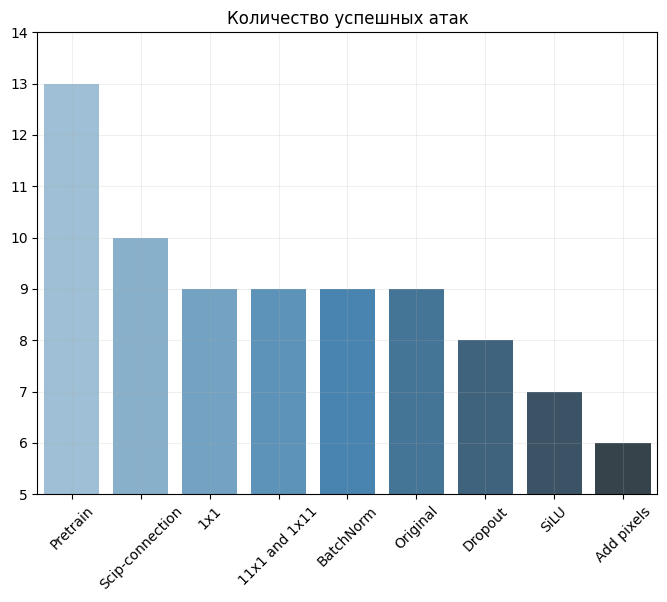

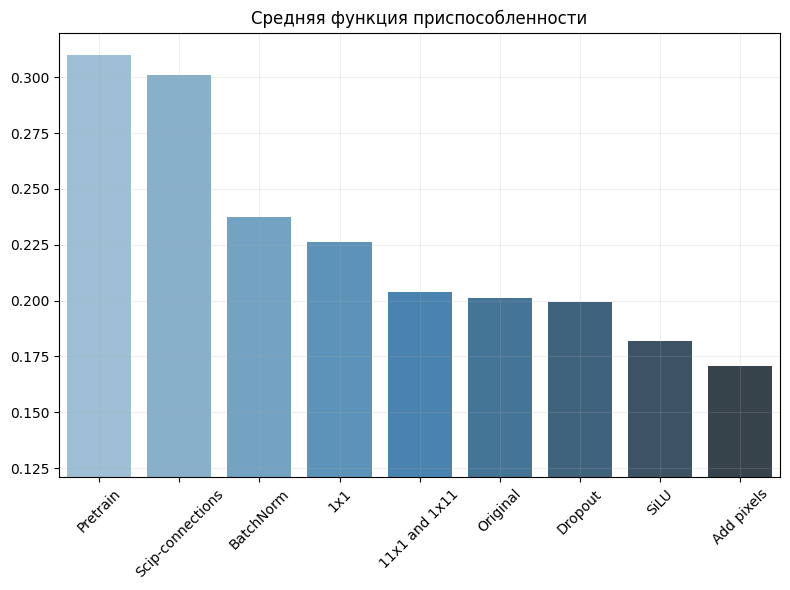

In [7]:
fig_accuracy, ax_accuracy = plt.subplots(figsize=(8, 6))
fig_f, ax_f = plt.subplots(figsize=(8, 6))

sns.barplot(x=models, y=metrics['Количество успешных атак'], ax=ax_accuracy, palette='Blues_d')
ax_accuracy.set_title('Количество успешных атак')
ax_accuracy.tick_params(axis='x', labelrotation=45)
ax_accuracy.grid(alpha=0.2)
ax_accuracy.set_ylim([min(metrics['Количество успешных атак']) - 1, max(metrics['Количество успешных атак']) + 1]) 

sns.barplot(x=models2, y=metrics2['Средняя функция приспособленности'], ax=ax_f, palette='Blues_d')
ax_f.set_title('Средняя функция приспособленности')
ax_f.tick_params(axis='x', labelrotation=45)
ax_f.set_ylim([min(metrics2['Средняя функция приспособленности']) - 0.05, max(metrics2['Средняя функция приспособленности']) + 0.01]) 
ax_f.grid(alpha=0.2)
fig_f.tight_layout()

# ResNet

In [7]:
import pickle
with open('results/true_images_resnet.pickle', 'rb') as f:
    true_images_x, true_images_y = pickle.load(f)

In [8]:
true_images_x = true_images_x[:30]
true_images_y = true_images_y[:30]
true_images_x.shape, true_images_y.shape 

((30,), (30,))

## Original

In [9]:
resnet_18_model = models.resnet18()
resnet_18_model.fc = nn.Linear(512, 1)
resnet_18_model.load_state_dict(torch.load('models/best_resnet18_2.pth'))
resnet_18_model.eval()
resnet_18_model.to(DEVICE)
pass

In [10]:
%%time
resnet_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=resnet_18_model,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    resnet_results.append(attack)
    clear_output()

CPU times: user 9h 13min 26s, sys: 23min 23s, total: 9h 36min 49s
Wall time: 3h 30min 42s


In [11]:
resnet_results

[[92,
  73,
  50,
  47,
  26,
  93,
  88,
  20,
  4,
  72,
  151,
  105,
  243,
  1,
  27,
  0.17904986441135406],
 [111,
  73,
  18,
  251,
  234,
  111,
  60,
  5,
  245,
  251,
  148,
  50,
  253,
  223,
  249,
  0.50359046459198],
 [122,
  108,
  83,
  7,
  3,
  122,
  57,
  2,
  0,
  15,
  121,
  117,
  207,
  0,
  15,
  np.float32(0.017942786)],
 [111,
  75,
  53,
  248,
  223,
  111,
  60,
  7,
  252,
  253,
  160,
  73,
  223,
  3,
  235,
  0.506009578704834],
 [61,
  101,
  133,
  236,
  254,
  59,
  76,
  196,
  205,
  246,
  59,
  89,
  72,
  252,
  208,
  0.0008352375007234514],
 [127,
  114,
  10,
  71,
  147,
  58,
  105,
  9,
  252,
  151,
  124,
  63,
  25,
  2,
  7,
  0.0029280998278409243],
 [112,
  111,
  29,
  240,
  215,
  108,
  101,
  240,
  153,
  183,
  159,
  92,
  186,
  0,
  0,
  0.5186925530433655],
 [123,
  110,
  234,
  3,
  14,
  123,
  98,
  143,
  4,
  23,
  124,
  66,
  2,
  3,
  4,
  np.float32(0.50311154)],
 [69,
  62,
  137,
  250,
  250,
  54,
  1

In [12]:
import pickle
with open('results/_result_resnet_18.pickle', 'wb') as f:
    pickle.dump(resnet_results, f)

In [13]:
len([e[15] for e in resnet_results if e[15] > 0.5])

9

In [14]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in resnet_results])

np.float64(0.21336825898761164)

## Pretrain

In [15]:
resnet_18_pretrain_model = models.resnet18()
resnet_18_pretrain_model.fc = nn.Linear(512, 1)
resnet_18_pretrain_model.load_state_dict(torch.load('models/best_resnet18_pretrain.pth'))
resnet_18_pretrain_model.eval()
resnet_18_pretrain_model.to(DEVICE)
pass

In [16]:
%%time
resnet_pretrain_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=resnet_18_pretrain_model,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    resnet_pretrain_results.append(attack)
    clear_output()

CPU times: user 7h 24min 8s, sys: 18min 3s, total: 7h 42min 11s
Wall time: 2h 48min 20s


In [17]:
resnet_pretrain_results

[[104,
  88,
  2,
  5,
  84,
  150,
  100,
  230,
  0,
  250,
  215,
  24,
  67,
  50,
  30,
  0.49615776538848877],
 [110,
  61,
  20,
  175,
  181,
  164,
  56,
  199,
  220,
  231,
  205,
  141,
  160,
  66,
  171,
  0.5371202230453491],
 [126,
  57,
  19,
  1,
  10,
  122,
  110,
  30,
  0,
  184,
  129,
  121,
  7,
  1,
  5,
  np.float32(0.0072426796)],
 [148,
  43,
  251,
  235,
  126,
  100,
  87,
  208,
  254,
  149,
  9,
  106,
  30,
  186,
  153,
  0.5080078840255737],
 [125,
  93,
  27,
  23,
  44,
  115,
  61,
  0,
  42,
  12,
  150,
  77,
  243,
  4,
  86,
  0.007411133497953415],
 [92,
  88,
  222,
  4,
  28,
  190,
  95,
  4,
  4,
  0,
  116,
  101,
  3,
  2,
  5,
  0.010034783743321896],
 [108,
  104,
  247,
  250,
  31,
  106,
  88,
  30,
  21,
  137,
  148,
  95,
  14,
  45,
  239,
  0.5019477605819702],
 [129,
  96,
  253,
  39,
  172,
  130,
  108,
  22,
  6,
  115,
  123,
  63,
  119,
  114,
  118,
  np.float32(0.5257789)],
 [116,
  64,
  251,
  251,
  237,
  180,


In [18]:
import pickle
with open('results/_result_resnet_18_pretrain.pickle', 'wb') as f:
    pickle.dump(resnet_pretrain_results, f)

In [19]:
len([e[15] for e in resnet_pretrain_results if e[15] > 0.5])

9

In [20]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in resnet_pretrain_results])

np.float64(0.21577825187438673)

## SiLU

In [21]:
resnet_18_silu_model = resnet18()
resnet_18_silu_model.fc = nn.Linear(512, 1)
resnet_18_silu_model.load_state_dict(torch.load('models/best_resnet_silu.pth'))
resnet_18_silu_model.eval()
resnet_18_silu_model.to(DEVICE)
pass

In [22]:
%%time
resnet_silu_results = []
for i, (image_path, label) in enumerate(zip(true_images_x, true_images_y)):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=resnet_18_silu_model,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=1000,
        timeout=10*60,
    )
    resnet_silu_results.append(attack)
    clear_output()

CPU times: user 7h 54min 1s, sys: 19min 58s, total: 8h 13min 59s
Wall time: 3h 4s


In [23]:
resnet_silu_results

[[93,
  73,
  82,
  40,
  11,
  152,
  100,
  251,
  1,
  68,
  161,
  76,
  15,
  60,
  168,
  0.13082721829414368],
 [111,
  61,
  139,
  175,
  230,
  177,
  59,
  99,
  119,
  198,
  109,
  73,
  30,
  228,
  183,
  0.5153931379318237],
 [125,
  124,
  48,
  4,
  3,
  125,
  57,
  60,
  6,
  0,
  122,
  111,
  11,
  8,
  8,
  np.float32(0.037360072)],
 [111,
  115,
  18,
  251,
  252,
  111,
  101,
  6,
  241,
  249,
  111,
  61,
  1,
  254,
  253,
  0.4090138077735901],
 [122,
  73,
  113,
  1,
  21,
  59,
  89,
  174,
  251,
  236,
  59,
  76,
  251,
  252,
  237,
  0.0025986009277403355],
 [129,
  67,
  59,
  7,
  5,
  191,
  85,
  145,
  26,
  11,
  55,
  74,
  191,
  194,
  243,
  0.005154664162546396],
 [157,
  92,
  187,
  0,
  26,
  109,
  114,
  1,
  244,
  237,
  91,
  87,
  112,
  96,
  143,
  0.528672993183136],
 [168,
  86,
  34,
  112,
  9,
  129,
  64,
  45,
  21,
  235,
  133,
  103,
  166,
  11,
  88,
  np.float32(0.5060546)],
 [129,
  90,
  3,
  36,
  29,
  187,
 

In [24]:
import pickle
with open('results/_result_resnet_18_silu.pickle', 'wb') as f:
    pickle.dump(resnet_silu_results, f)

In [25]:
len([e[15] for e in resnet_silu_results if e[15] > 0.5])

9

In [26]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in resnet_silu_results])

np.float64(0.2114346181403865)

## Resnet101

In [7]:
resnet_101_model = models.resnet101()
resnet_101_model.fc = nn.Linear(2048, 1)
resnet_101_model.load_state_dict(torch.load('models/best_resnet_101.pth'))
resnet_101_model.eval()
resnet_101_model.to(DEVICE)
pass

In [13]:
%%time
for i, (image_path, label) in enumerate(zip(true_images_x[16:], true_images_y[16:])):
    print(f'{i}/{len(true_images_x)}, {image_path}')
    img_ = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
    attack = ga_one_pixel_attack(
        img=img_,
        true_label=label,
        model=resnet_101_model,
        pixels_count=3,
        diameter=2,
        epochs=1000,
        population_size=800,
        timeout=10*60,
    )
    resnet_101_results.append(attack)
    clear_output()

CPU times: user 4h 7min 42s, sys: 8min 8s, total: 4h 15min 51s
Wall time: 2h 9min 53s


In [18]:
import pickle
with open('results/_result_resnet_101.pickle', 'wb') as f:
    pickle.dump(resnet_101_results, f)

In [19]:
len([e[15] for e in resnet_101_results if e[15] > 0.5])

4

In [20]:
np.mean([e[15] if e[15] < 0.5 else 0.5 for e in resnet_101_results])

np.float64(0.15120176320412831)

In [21]:
resnet_101_results

[[185,
  128,
  198,
  31,
  149,
  95,
  62,
  9,
  3,
  152,
  97,
  70,
  23,
  95,
  52,
  0.33906838297843933],
 [111,
  77,
  250,
  162,
  184,
  158,
  91,
  228,
  19,
  227,
  92,
  76,
  207,
  156,
  147,
  0.505020797252655],
 [134,
  116,
  22,
  43,
  15,
  121,
  60,
  0,
  1,
  3,
  121,
  111,
  83,
  6,
  1,
  np.float32(0.0067254305)],
 [111,
  117,
  6,
  243,
  242,
  95,
  92,
  207,
  229,
  238,
  162,
  85,
  249,
  8,
  250,
  0.5095794200897217],
 [91,
  88,
  175,
  7,
  195,
  128,
  88,
  73,
  132,
  19,
  95,
  76,
  51,
  4,
  8,
  0.0024682260118424892],
 [115,
  101,
  4,
  61,
  4,
  127,
  87,
  92,
  65,
  87,
  98,
  88,
  93,
  16,
  10,
  0.00303062004968524],
 [127,
  66,
  19,
  97,
  17,
  127,
  107,
  243,
  0,
  95,
  128,
  95,
  249,
  17,
  232,
  np.float32(0.3827381)],
 [150,
  41,
  209,
  37,
  86,
  128,
  89,
  76,
  77,
  70,
  114,
  24,
  16,
  37,
  83,
  0.00013093187590129673],
 [114,
  63,
  240,
  253,
  251,
  149,
  38,

## Result

In [5]:
import seaborn as sns
metrics = {
    'Количество успешных атак': [9, 9, 9, 4],
}
models = ["Original", "Pretrain", "SiLU", "ResNet101"]

metrics2 = {
    'Средняя функция приспособленности': [0.2157, 0.2133, 0.2114, 0.1512],
}

models2 = ["Pretrain", "Original", "SiLU", "ResNet101"]

/tmp/ipykernel_2417/126290050.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metrics['Количество успешных атак'], ax=ax_accuracy, palette='Blues_d')
/tmp/ipykernel_2417/126290050.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models2, y=metrics2['Средняя функция приспособленности'], ax=ax_f, palette='Blues_d')


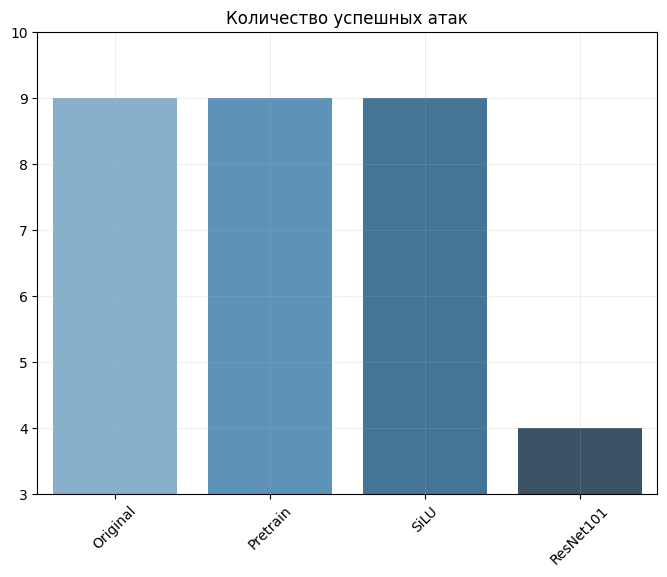

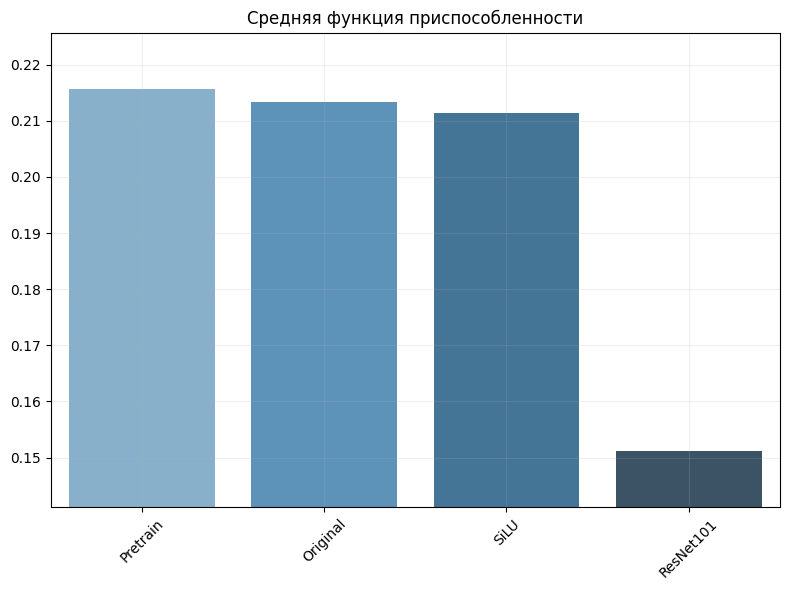

In [7]:
fig_accuracy, ax_accuracy = plt.subplots(figsize=(8, 6))
fig_f, ax_f = plt.subplots(figsize=(8, 6))

sns.barplot(x=models, y=metrics['Количество успешных атак'], ax=ax_accuracy, palette='Blues_d')
ax_accuracy.set_title('Количество успешных атак')
ax_accuracy.tick_params(axis='x', labelrotation=45)
ax_accuracy.grid(alpha=0.2)
ax_accuracy.set_ylim([min(metrics['Количество успешных атак']) - 1, max(metrics['Количество успешных атак']) + 1]) 

sns.barplot(x=models2, y=metrics2['Средняя функция приспособленности'], ax=ax_f, palette='Blues_d')
ax_f.set_title('Средняя функция приспособленности')
ax_f.tick_params(axis='x', labelrotation=45)
ax_f.set_ylim([min(metrics2['Средняя функция приспособленности']) - 0.01, max(metrics2['Средняя функция приспособленности']) + 0.01]) 
ax_f.grid(alpha=0.2)
fig_f.tight_layout()